In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import gym

plt.rcParams['figure.figsize'] = (15, 7)

In [3]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    argmax_action = np.argmax(q_values)
    probs = epsilon * np.ones(action_n) / action_n
    probs[argmax_action] += 1 - epsilon
    action = np.random.choice(np.arange(action_n), p = probs)
    return action

In [32]:
class CrossEntropyAgent():
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n
        self.model = np.ones((state_n, action_n)) / action_n
    
    def get_action(self, state):
        action = np.random.choice(np.arange(self.action_n), p = self.model[state])
        return int(action)
    
    def fit(self, elite_trajectories):
        new_model = np.zeros((state_n, action_n))
        
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                new_model[state][action] += 1
        
        for state in range(self.state_n):
            if np.sum(new_model[state]) > 0:
                new_model[state] /= np.sum(new_model[state])
            else:
                new_model[state] = self.model[state].copy()
            
        self.model = new_model
        
        return None
    
    
def get_state(obs):
    return int(obs)

def get_trajectory(env, agent, max_len=1000, visualize=False):
    trajectory = {'states': [], 'actions': [], 'rewards': []}

    obs = env.reset()
    state = get_state(obs)
    
    for _ in range(max_len):
        trajectory['states'].append(state)
        
        action = agent.get_action(state)
        trajectory['actions'].append(action)
        
        obs, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)
        
        state = get_state(obs)
        
        if visualize:
            time.sleep(0.1)
            env.render()
        
        if done:
            break
        
    return trajectory

def MonteCarlo(env, episode_n, t_max = 500, gamma = 0.99):
    state_n = env.observation_space.n
    action_n = env.action_space.n
    
    Q = np.zeros((state_n, action_n))
    N = np.zeros((state_n, action_n))
    epsilon = 1
    
    total_rewards = []
    for episode in range(episode_n):
        states, actions, rewards = [], [], []
        
        state = env.reset()
        for t in range(t_max):
            states.append(state)
            
            action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
            actions.append(action)
            
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            
            
            if done:
                break
            
        total_rewards.append(sum(rewards))
        
        G = np.zeros(len(rewards))
        G[-1] = rewards[-1]
        
        for t in range(len(rewards) - 2, -1, -1):
            G[t] = rewards[t] + gamma * G[t + 1]
        
        for t in range(len(rewards)):
            Q[states[t]][actions[t]] += (G[t] - Q[states[t]][actions[t]]) / (N[states[t]][actions[t]] + 1)
            N[states[t]][actions[t]] += 1
        
        epsilon -= 1 / episode_n
        
    return total_rewards

def SARSA(env, episode_n, t_max = 500, gamma = 0.99, alpha = 0.5):
    state_n = env.observation_space.n
    action_n = env.action_space.n
    
    Q = np.zeros((state_n, action_n))
    epsilon = 1
    
    total_rewards = []
    for episode in range(episode_n):
        total_reward = 0
        state = env.reset()
        action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
        
        for t in range(t_max):

            next_state, reward, done, _ = env.step(action)
            next_action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
            total_reward += reward
            
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            
            state = next_state
            action = next_action
            
            if done:
                break
            
        total_rewards.append(total_reward)
        epsilon -= 1 / episode_n
        
    return total_rewards

def Qlearning(env, episode_n, t_max = 500, gamma = 0.99, alpha = 0.5):
    state_n = env.observation_space.n
    action_n = env.action_space.n
    
    Q = np.zeros((state_n, action_n))
    epsilon = 1
    
    total_rewards = []
    for episode in range(episode_n):
        total_reward = 0
        state = env.reset()

        for t in range(t_max):
            
            action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            Q[state][action] += alpha * (reward + gamma * Q[next_state][np.argmax(Q[next_state])] - Q[state][action])
            
            state = next_state
            
            if done:
                break
            
        total_rewards.append(total_reward)
        epsilon -= 1 / episode_n
        
    return total_rewards

def CEA(env, episode_n, t_max = 1000):
    action_n = 6
    state_n = 500

    agent = CrossEntropyAgent(state_n, action_n)
    q_param = 0.8
    trajectory_n = t_max
    iteration_n = episode_n
    max_len = 1000

    agent = CrossEntropyAgent(state_n, action_n)

    mean_rewards_arr = []

    for iteration in range(iteration_n):
        
        # evaluation
        trajectories = [get_trajectory(env, agent, max_len) for _ in range(trajectory_n)]
        total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
        # print('iteration:', iteration,'mean total reward:', np.mean(total_rewards))
        mean_rewards_arr.append(np.mean(total_rewards))
        
        # improvement
        quantile = np.quantile(total_rewards, q_param)
        elite_trajectories = [trajectory for trajectory in trajectories if np.sum(trajectory['rewards']) > quantile]
        
        agent.fit(elite_trajectories)
        
    return mean_rewards_arr

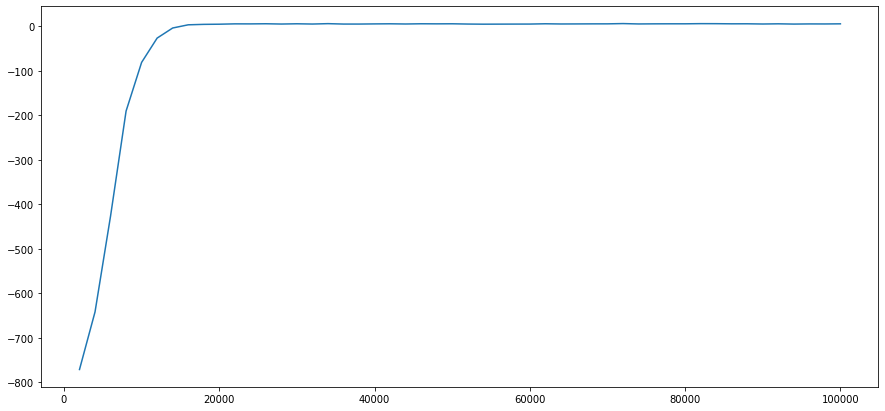

In [37]:
env = gym.make('Taxi-v3')

t_max = 2000
episodes = 50
total_rewards_cea = CEA(env, episode_n = episodes, t_max = t_max)
    
plt.plot(np.arange(t_max, t_max * episodes + t_max, t_max), total_rewards_cea)

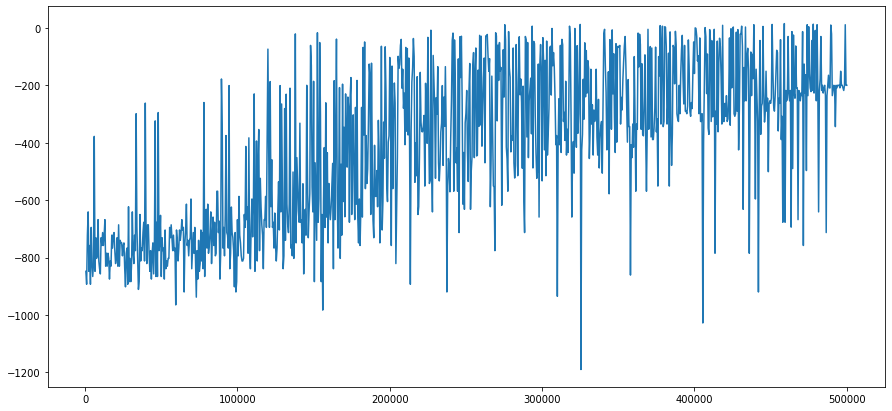

In [38]:
env = gym.make('Taxi-v3')

t_max = 500
episodes = 1000

total_rewards_mc = MonteCarlo(env, episode_n = episodes, t_max = t_max)

plt.plot(np.arange(t_max, t_max * episodes + t_max, t_max), total_rewards_mc)

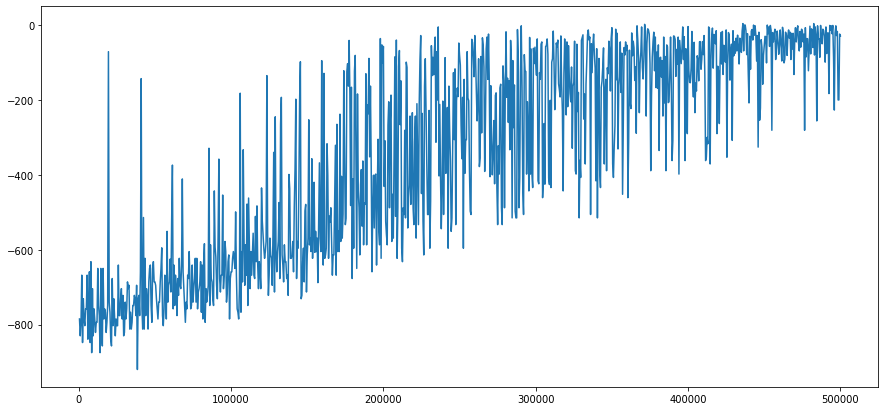

In [39]:
env = gym.make('Taxi-v3')

t_max = 500
episodes = 1000

total_rewards_sarsa = SARSA(env, episode_n = episodes, t_max = t_max)

plt.plot(np.arange(t_max, t_max * episodes + t_max, t_max), total_rewards_sarsa)

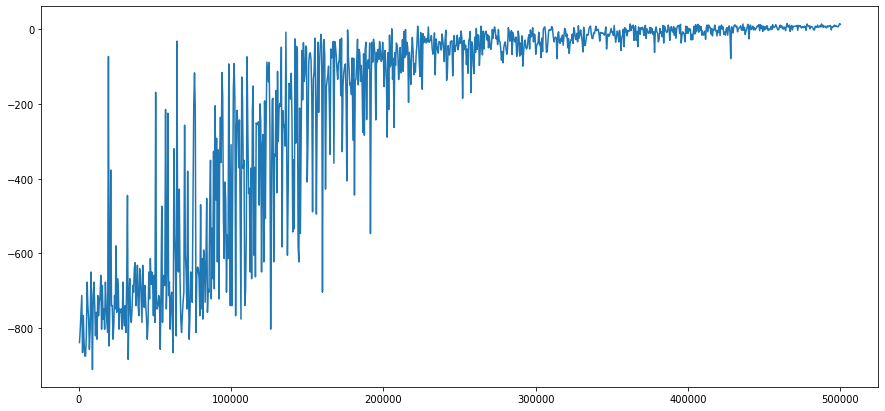

In [40]:
env = gym.make('Taxi-v3')

t_max = 500
episodes = 1000

total_rewards_q = Qlearning(env, episode_n = episodes, t_max = 500)

plt.plot(np.arange(t_max, t_max * episodes + t_max, t_max), total_rewards_q)

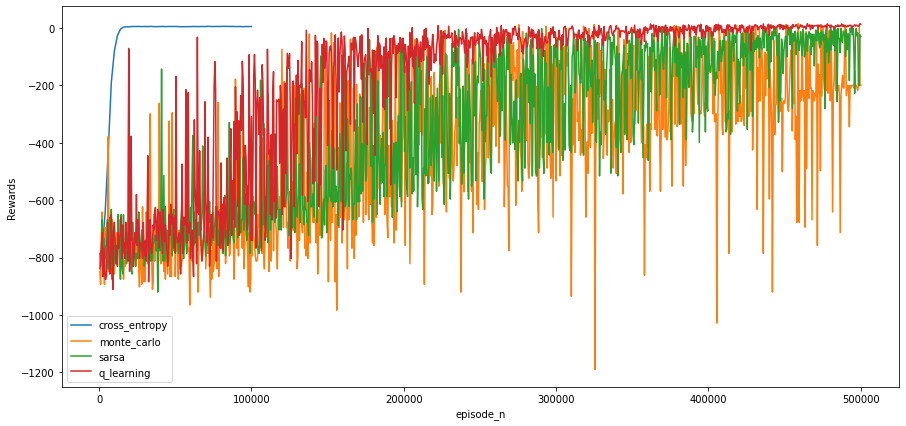

In [59]:
plt.plot(np.arange(2000, 2000 * 50 + 2000, 2000), total_rewards_cea, label = 'cross_entropy')
plt.plot(np.arange(500, 500 * 1000 + 500, 500), total_rewards_mc, label = 'monte_carlo')
plt.plot(np.arange(500, 500 * 1000 + 500, 500), total_rewards_sarsa, label = 'sarsa')
plt.plot(np.arange(500, 500 * 1000 + 500, 500), total_rewards_q, label = 'q_learning')
plt.ylabel("Rewards")
plt.xlabel("episode_n")
plt.legend(loc = 'best')